# Method of Simulated Moments (MSM)

This tutorial shows you how to do a Method of Simulated Moments estimation in estimagic. The Method of Simulated Moments (MSM) is a nonlinear estimation principle that is very useful for fitting complicated models to the data. The only ingredient required is a function that simulates the model outcomes you observe in some empirical dataset. 

In the tutorial here, we will use a simple linear regression model. This is the same model which we use in the tutorial on maximum likelihood estimation.

Throughout the tutorial, we only talk about MSM estimation. However, the more general case of indirect inference estimation works exactly the same way. 


## Steps of MSM estimation

1. Load (simulate) empirical data 
2. Define a function to calculate estimation moments on the data 
3. Calculate the covariance matrix of the empirical moments (with ``get_moments_cov``)
4. Define a function to simulate moments from the model 
5. Estimate the model, calculate standard errors, do sensitivity analysis (with ``estimate_msm``)

## Example: Estimate the parameters of a regression model

The model we consider here is a simple regression model with only one explanatory variable (plus a constant). The goal is to estimate the slope coefficients and the error variance from a simulated data set.

The estimation mechanics are exactly the same for more complicated models. A model is always defined by a function that can take parameters (here: the mean, variance and lower_cutoff and upper_cutoff) and returns a number of simulated moments (mean, variance, soft_min and soft_max of simulated exam points).

### Model:

$$ y = \beta_0 + \beta_1 x + \epsilon, \text{ where } \epsilon \sim N(0, \sigma^2)$$

We aim to estimate $\beta_0, \beta_1, \sigma^2$.

In [1]:
import numpy as np
import pandas as pd

import estimagic as em

rng = np.random.default_rng(seed=0)

## 1. Simulate data

In [2]:
def simulate_data(params, n_draws, rng):
    x = rng.normal(0, 1, size=n_draws)
    e = rng.normal(0, params.loc["sd", "value"], size=n_draws)
    y = params.loc["intercept", "value"] + params.loc["slope", "value"] * x + e
    return pd.DataFrame({"y": y, "x": x})

In [3]:
true_params = pd.DataFrame(
    data=[[2, -np.inf], [-1, -np.inf], [1, 1e-10]],
    columns=["value", "lower_bound"],
    index=["intercept", "slope", "sd"],
)

data = simulate_data(true_params, n_draws=100, rng=rng)

## 2. Calculate Moments

In [4]:
def calculate_moments(sample):
    moments = {
        "y_mean": sample["y"].mean(),
        "x_mean": sample["x"].mean(),
        "yx_mean": (sample["y"] * sample["x"]).mean(),
        "y_sqrd_mean": (sample["y"] ** 2).mean(),
        "x_sqrd_mean": (sample["x"] ** 2).mean(),
    }
    return pd.Series(moments)

In [5]:
empirical_moments = calculate_moments(data)
empirical_moments

y_mean         1.868333
x_mean         0.081097
yx_mean       -0.723189
y_sqrd_mean    5.227749
x_sqrd_mean    0.932272
dtype: float64

## 3. Calculate the covariance matrix of empirical moments

The covariance matrix of the empirical moments (``moments_cov``) is needed for three things:
1. to calculate the weighting matrix
2. to calculate standard errors
3. to calculate sensitivity measures

We will calculate ``moments_cov`` via a bootstrap. Depending on your problem, there can be other ways to calculate the covariance matrix.

In [6]:
moments_cov = em.get_moments_cov(
    data, calculate_moments, bootstrap_kwargs={"n_draws": 5_000, "seed": 0}
)

moments_cov

,y_mean,x_mean,yx_mean,y_sqrd_mean,x_sqrd_mean
y_mean,0.018798,-0.009677,-0.016273,0.064690,-0.001008
x_mean,-0.009677,0.010296,0.018855,-0.035908,0.001664
yx_mean,-0.016273,0.018855,0.054389,-0.084103,-0.009772
y_sqrd_mean,0.064690,-0.035908,-0.084103,0.264784,0.007958
x_sqrd_mean,-0.001008,0.001664,-0.009772,0.007958,0.012245


``get_moments_cov`` mainly just calls estimagic's bootstrap function. See our [bootstrap_tutorial](../../how_to_guides/inference/how_to_do_bootstrap_inference.ipynb) for background information. 



## 4. Define a function to calculate simulated moments

In a real world application, this is the step that would take most of the time. However, in our very simple example, all the work is already done by numpy.

In [7]:
def simulate_moments(params, n_draws=10_000, seed=0):
    rng = np.random.default_rng(seed)
    sim_data = simulate_data(params, n_draws, rng)
    sim_moments = calculate_moments(sim_data)
    return sim_moments

In [8]:
simulate_moments(true_params)

y_mean         1.996739
x_mean         0.006312
yx_mean       -0.997919
y_sqrd_mean    5.999877
x_sqrd_mean    0.996197
dtype: float64

## 5. Estimate the model parameters

Estimating a model consists of the following steps:

- Building a criterion function that measures a distance between simulated and empirical moments
- Minimizing this criterion function
- Calculating the Jacobian of the model
- Calculating standard errors, confidence intervals and p-values
- Calculating sensitivity measures

This can all be done in one go with the ``estimate_msm`` function. This function has sensible default values, so you only need a minimum number of inputs. However, you can configure almost any aspect of the workflow via optional arguments. If you need even more control, you can call the lower level functions, which the now famliliar``estimate_msm`` function is built on, directly. 

In [9]:
start_params = true_params.assign(value=[100, 100, 100])

res = em.estimate_msm(
    simulate_moments,
    empirical_moments,
    moments_cov,
    start_params,
    optimize_options="scipy_lbfgsb",
)

In [10]:
res.summary()

,value,standard_error,ci_lower,ci_upper,p_value,free,stars
intercept,1.869534,0.138186,1.598695,2.140374,1.052737e-41,True,***
slope,-0.721958,0.236188,-1.184878,-0.259038,2.237811e-03,True,***
sd,1.099789,0.141133,0.823173,1.376405,6.566135e-15,True,***


## What's in the result?

`MomentsResult` objects provide attributes and methods to calculate standard errors, confidence intervals and p-values. For all three, several methods are available. You can even calculate cluster robust standard errors.

A few examples are:

In [11]:
res.params

,value,lower_bound
intercept,1.869534,-inf
slope,-0.721958,-inf
sd,1.099789,1.000000e-10


In [12]:
res.cov(method="robust")

,intercept,slope,sd
intercept,0.019095,-0.017086,-0.013917
slope,-0.017086,0.055785,0.026761
sd,-0.013917,0.026761,0.019919


In [13]:
res.se()

,value,lower_bound
intercept,0.138186,-inf
slope,0.236188,-inf
sd,0.141133,1.000000e-10


## How to visualize sensitivity measures?

For more background on the sensitivity measures and their interpretation, check out the [how to guide](../../how_to_guides/miscellaneous/how_to_visualize_and_interpret_sensitivity_measures.ipynb) on sensitivity measures. 

Here, we just show you how to plot them:

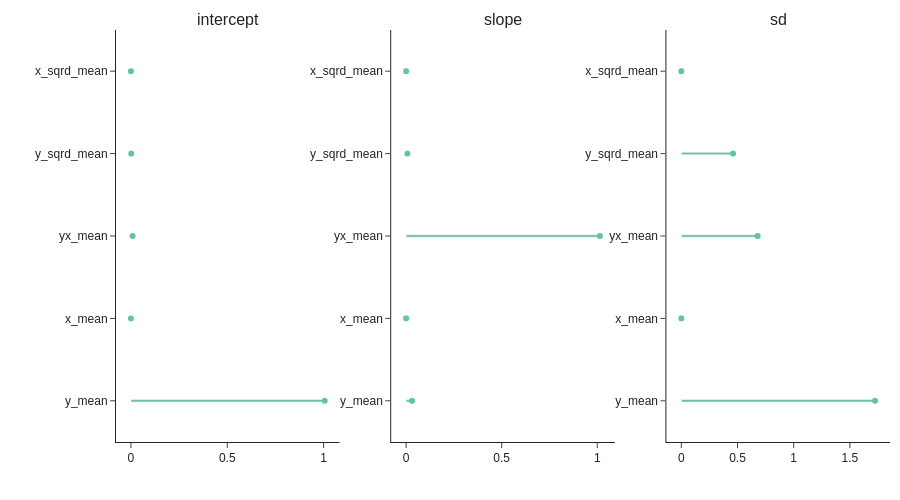

In [14]:
from estimagic.visualization.lollipop_plot import lollipop_plot

sensitivity_data = res.sensitivity(kind="bias").abs().T

fig = lollipop_plot(sensitivity_data)

fig = fig.update_layout(height=500, width=900)
fig.show(renderer="png")